[View in Colaboratory](https://colab.research.google.com/github/ccehshmily/learnDL/blob/master/tfs_data_preprocess.ipynb)

In [328]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import io
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

!wget https://raw.githubusercontent.com/ccehshmily/tfs/master/datasource/sampledata/sampleGOOG.txt -O /tmp/sample_data_GOOG.csv

--2018-05-20 05:00:14--  https://raw.githubusercontent.com/ccehshmily/tfs/master/datasource/sampledata/sampleGOOG.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218008 (213K) [text/plain]
Saving to: ‘/tmp/sample_data_GOOG.csv’

/tmp/sample_data_GO 100%[===================>] 212.90K  --.-KB/s    in 0.04s   

2018-05-20 05:00:14 (5.81 MB/s) - ‘/tmp/sample_data_GOOG.csv’ saved [218008/218008]



In [329]:
# Normalizes a list of values to the [-1, 1] range
def normalize_list(list_values):
  min_val = min(list_values)
  max_val = max(list_values)
  avg_val = (min_val + max_val) / 2.0
  range_val = (max_val - min_val) / 2.0
  return [(val - avg_val) / range_val for val in list_values]

def log_linear_normalize_list(list_values):
  min_val = min(list_values)
  return normalize_list([math.log(x+1.1-min_val) for x in list_values])

def log_normalize_list(list_values):
  return [math.log(x+1) for x in list_values]

# validate method
print log_normalize_list([3.8,1,2,3,4,5])

[1.5686159179138452, 0.6931471805599453, 1.0986122886681098, 1.3862943611198906, 1.6094379124341003, 1.791759469228055]


In [330]:
# Preprocess raw data saved in /tmp/sample_data_[code].csv, extract data from
# recent history, and save processed and normailized data to
# /tmp/processed_data_[code].csv and /tmp/normalized_data_[code].csv
def preprocess_raw_data(code, price_lookback, volume_lookback, change_lookback):
  sample_data = open("/tmp/sample_data_" + code + ".csv", 'r')
  sample_data_lines = sample_data.readlines()
  sample_data.close()

  # Read each line into a map from column name to value
  column_titles = sample_data_lines[0][:-1].split(',')
  mapped_data = []
  for one_line in sample_data_lines[1:]:
    one_day_data = {column_titles[i]:one_line[:-1].split(',')[i] for i in range(len(column_titles))}
    mapped_data.append(one_day_data)

  # Expand each days data by reading from past N days, cannot process the furthest N days
  processed_data = open("/tmp/processed_data_" + code + ".csv", 'w')
  expanded_titles = ["Date"] + ["price_" + str(i) for i in range(price_lookback*4+1)] + ["volume_" + str(i) for i in range(volume_lookback)] + ["change_" + str(i) for i in range(change_lookback+1)]
  processed_data.write(','.join(expanded_titles) + "\n")
  for i in range(len(mapped_data) - max(price_lookback, volume_lookback, change_lookback)):
    price_history = [mapped_data[i]["Open"]]
    volume_history = []
    change_history = []

    for j in range(max(price_lookback, volume_lookback, change_lookback)):
      if j < price_lookback:
        price_history.append(mapped_data[i+j+1]["Close"])
        price_history.append(mapped_data[i+j+1]["High"])
        price_history.append(mapped_data[i+j+1]["Low"])
        price_history.append(mapped_data[i+j+1]["Open"])
      if j < volume_lookback:
        volume_history.append(mapped_data[i+j+1]["Volume"])
      if j < change_lookback:
        change_history.append(str((float(mapped_data[i+j+1]["Close"]) - float(mapped_data[i+j+1]["Open"])) / float(mapped_data[i+j+1]["Open"]) * 100.00))

    # Add today's change, this will be the label that we try to predict
    change_history.append(str((float(mapped_data[i]["Close"]) - float(mapped_data[i]["Open"])) / float(mapped_data[i]["Open"]) * 100.00))

    one_day_data = [code + "-" + mapped_data[i]["Date"]] + price_history + volume_history + change_history
    processed_data.write(','.join(one_day_data) + "\n")
  processed_data.close()

  # Normalize data
  pre_normalized_file = open("/tmp/processed_data_" + code + ".csv", 'r')
  pre_normalized_data = pre_normalized_file.readlines()
  pre_normalized_file.close()

  normalized_data = open("/tmp/normalized_data_" + code + ".csv", 'w')
  normalized_data.write(pre_normalized_data[0])
  for one_line in pre_normalized_data[1:]:
    one_day_data = one_line[:-1].split(',')
    price_data = [float(price) for price in one_day_data[1:1+price_lookback*4+1]]
    volume_data = [float(volume) for volume in one_day_data[1+price_lookback*4+1:1+price_lookback*4+1+volume_lookback]]
    change_data = [float(change) for change in one_day_data[1+price_lookback*4+1+volume_lookback:]]
    
    nor_price_data = [str(price) for price in normalize_list(price_data)]
    nor_volume_data = [str(volume) for volume in normalize_list(volume_data)]
    nor_change_data = [str(change) for change in normalize_list(change_data)]
    
    nor_one_day_data = ','.join([one_day_data[0]] + nor_price_data + nor_volume_data + nor_change_data)
    normalized_data.write(nor_one_day_data + "\n")
  normalized_data.close()

code = "GOOG"
price_lookback = 10
volume_lookback = 25
change_lookback = 25

preprocess_raw_data(code, price_lookback, volume_lookback, change_lookback)

# validate method
f1 = open("/tmp/processed_data_GOOG.csv", 'r')
f2 = open("/tmp/normalized_data_GOOG.csv", 'r')
print f1.readline()
print f1.readline()
print f2.readline()
print f2.readline()
print len(f2.readlines())

Date,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9,price_10,price_11,price_12,price_13,price_14,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24,price_25,price_26,price_27,price_28,price_29,price_30,price_31,price_32,price_33,price_34,price_35,price_36,price_37,price_38,price_39,price_40,volume_0,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,volume_13,volume_14,volume_15,volume_16,volume_17,volume_18,volume_19,volume_20,volume_21,volume_22,volume_23,volume_24,change_0,change_1,change_2,change_3,change_4,change_5,change_6,change_7,change_8,change_9,change_10,change_11,change_12,change_13,change_14,change_15,change_16,change_17,change_18,change_19,change_20,change_21,change_22,change_23,change_24,change_25

GOOG-2016-05-24,706.859985,704.23999,711.478027,704.179993,706.530029,709.73999,714.580017,700.52002,701.619995,700.320007,706.00,696.799988,702.

In [331]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.4f}'.format

normalized_google_data = pd.read_csv("/tmp/normalized_data_GOOG.csv", sep=",")
display.display(normalized_google_data.describe())

,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9,...,change_16,change_17,change_18,change_19,change_20,change_21,change_22,change_23,change_24,change_25
count,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,...,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000,2937.0000
mean,0.1346,0.1072,0.3742,-0.1676,0.1138,0.0866,0.3538,-0.1869,0.0943,0.0675,...,0.0033,0.0021,0.0021,0.0026,0.0028,0.0014,0.0014,0.0019,0.0019,-0.0042
std,0.6400,0.6095,0.5514,0.5855,0.5515,0.5367,0.4955,0.5252,0.5072,0.4998,...,0.5139,0.5149,0.5163,0.5160,0.5181,0.5189,0.5195,0.5221,0.5230,0.5107
min,-1.0000,-1.0000,-0.9590,-1.0000,-1.0000,-1.0000,-0.9590,-1.0000,-1.0000,-1.0000,...,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
25%,-0.4475,-0.4484,-0.1306,-0.7399,-0.3930,-0.3892,-0.0592,-0.6519,-0.3242,-0.3342,...,-0.3557,-0.3578,-0.3672,-0.3617,-0.3616,-0.3600,-0.3610,-0.3617,-0.3553,-0.3617
50%,0.2230,0.1709,0.4865,-0.1353,0.1821,0.1403,0.4352,-0.1621,0.1296,0.0961,...,0.0078,0.0050,0.0069,0.0061,0.0080,0.0118,0.0123,0.0185,0.0167,-0.0106
75%,0.7275,0.6814,0.9075,0.3761,0.6045,0.5652,0.7914,0.2708,0.5241,0.4862,...,0.3690,0.3718,0.3753,0.3770,0.3813,0.3807,0.3760,0.3794,0.3766,0.3584
max,1.0000,1.0000,1.0000,0.8410,1.0000,0.9906,1.0000,0.8200,1.0000,0.9862,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [332]:
google_data = normalized_google_data.head(1500)
google_data = google_data.reindex(np.random.permutation(google_data.index))
google_data.head()

,Date,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,...,change_16,change_17,change_18,change_19,change_20,change_21,change_22,change_23,change_24,change_25
1068,GOOG-2012-02-24,-0.0452,-0.1682,0.0134,-0.7399,-0.0799,0.0134,0.8908,-0.1087,0.4124,...,-0.5244,-0.2935,0.5981,-0.6216,-1.0000,-0.7500,-0.3040,-0.6698,-0.3783,-0.0367
1117,GOOG-2011-12-13,0.8758,0.7425,0.7738,0.5408,0.6037,0.8228,0.8904,0.4111,0.4503,...,-0.8677,-0.2172,0.1129,0.2096,0.3716,-1.0000,-0.4247,0.0828,1.0000,-0.4015
308,GOOG-2015-03-05,0.9144,0.8469,1.0000,0.6275,0.7855,0.8580,0.9296,0.5665,0.7274,...,-0.2041,0.0167,0.0453,-0.5974,-0.1160,-0.3951,1.0000,-0.2154,-1.0000,-0.1757
1492,GOOG-2010-06-21,0.6475,0.6552,0.8583,0.5430,0.8016,0.6581,1.0000,0.4579,0.8571,...,-0.5365,0.5927,-0.3205,0.1555,-0.7796,-0.1915,-0.8508,0.0166,-0.2159,-0.8467
1353,GOOG-2011-01-06,1.0000,0.8273,0.9625,-0.1399,-0.1378,0.0820,0.5174,-0.1324,0.4574,...,-0.7454,-0.5072,-0.7291,-0.5843,-1.0000,-0.7108,0.2026,0.1410,-0.1464,0.0556


In [0]:
def parse_labels_and_features(dataset, price_lookback, volume_lookback, change_lookback):
  labels = dataset["change_" + str(change_lookback)].apply(lambda x: int(max(1, math.ceil((x+1)*4))-1)).apply(np.int64)

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.loc[:,"price_0":"change_" + str(change_lookback-1)]

  return labels, features

In [334]:
training_targets, training_examples = parse_labels_and_features(google_data[:1200], price_lookback, volume_lookback, change_lookback)
training_examples.describe()

,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9,...,change_15,change_16,change_17,change_18,change_19,change_20,change_21,change_22,change_23,change_24
count,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,...,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000,1200.0000
mean,0.1419,0.1183,0.3868,-0.1542,0.1316,0.1095,0.3698,-0.1635,0.1161,0.0969,...,0.0103,0.0091,0.0291,0.0147,0.0193,0.0156,0.0099,0.0178,0.0106,0.0274
std,0.6372,0.6124,0.5525,0.5935,0.5528,0.5417,0.4996,0.5345,0.5125,0.5085,...,0.5245,0.5203,0.5195,0.5216,0.5202,0.5312,0.5292,0.5298,0.5230,0.5245
min,-1.0000,-0.9991,-0.9590,-1.0000,-1.0000,-0.9986,-0.9590,-1.0000,-1.0000,-0.9985,...,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
25%,-0.4211,-0.4261,-0.1056,-0.7430,-0.3686,-0.3612,-0.0497,-0.6371,-0.3067,-0.3238,...,-0.3786,-0.3606,-0.3430,-0.3613,-0.3517,-0.3861,-0.3787,-0.3619,-0.3612,-0.3486
50%,0.2509,0.1884,0.5193,-0.0969,0.2314,0.1769,0.4765,-0.1232,0.1854,0.1549,...,0.0321,0.0386,0.0419,0.0284,0.0235,0.0319,0.0138,0.0538,0.0367,0.0501
75%,0.7334,0.6889,0.9119,0.3911,0.6206,0.5820,0.8042,0.3070,0.5555,0.5278,...,0.3991,0.3800,0.4061,0.3997,0.4084,0.4177,0.4059,0.4096,0.4064,0.4106
max,1.0000,1.0000,1.0000,0.8224,1.0000,0.9906,1.0000,0.8200,1.0000,0.9862,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [0]:
#_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [336]:
training_targets.describe()

count   1200.0000
mean       3.5533
std        2.0686
min        0.0000
25%        2.0000
50%        4.0000
75%        5.0000
max        7.0000
Name: change_25, dtype: float64

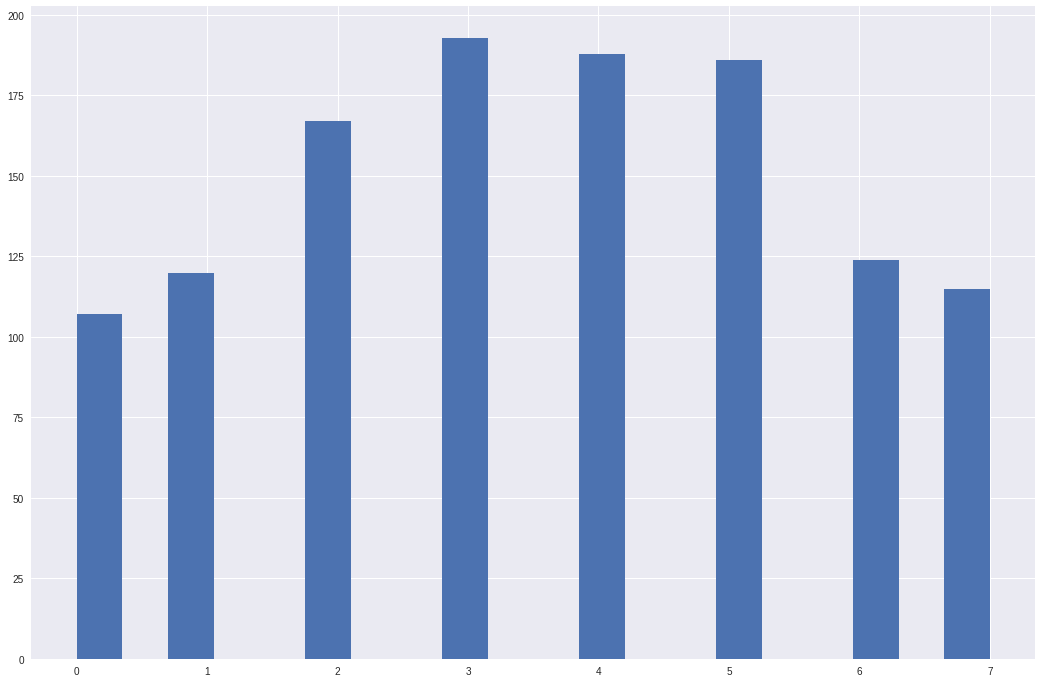

In [337]:
_ = training_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [338]:
validation_targets, validation_examples = parse_labels_and_features(google_data[1200:1500], price_lookback, volume_lookback, change_lookback)
validation_examples.describe()

,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9,...,change_15,change_16,change_17,change_18,change_19,change_20,change_21,change_22,change_23,change_24
count,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,...,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000
mean,0.0831,0.0686,0.3164,-0.2322,0.0527,0.0301,0.3020,-0.2675,0.0372,0.0012,...,0.0436,0.0586,-0.0266,0.0353,0.0259,0.0365,0.0524,0.0248,0.0515,-0.0139
std,0.6611,0.6267,0.5722,0.5808,0.5599,0.5502,0.5144,0.5223,0.5147,0.5109,...,0.5115,0.5318,0.5396,0.5351,0.5437,0.5157,0.5145,0.5089,0.5375,0.5452
min,-1.0000,-1.0000,-0.9529,-1.0000,-0.9824,-0.9877,-0.9573,-1.0000,-1.0000,-0.9966,...,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
25%,-0.5258,-0.5138,-0.2218,-0.7927,-0.4797,-0.4837,-0.1210,-0.7446,-0.3833,-0.4040,...,-0.3116,-0.3284,-0.4233,-0.3787,-0.3927,-0.3023,-0.2869,-0.3422,-0.3551,-0.4384
50%,0.2038,0.1575,0.4235,-0.2360,0.0964,0.0724,0.3672,-0.2589,0.0675,-0.0253,...,0.0417,0.0359,-0.0230,0.0519,0.0482,0.0391,0.1128,-0.0117,0.0750,0.0436
75%,0.6844,0.6635,0.8456,0.3478,0.5538,0.5020,0.7732,0.1535,0.4604,0.4379,...,0.3989,0.4734,0.3754,0.4296,0.4366,0.3811,0.4129,0.4039,0.4384,0.4089
max,1.0000,0.9927,1.0000,0.7551,1.0000,0.9777,1.0000,0.7617,0.9891,0.9651,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [0]:
def construct_feature_columns(price_lookback, volume_lookback, change_lookback):
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column('features', shape=1+price_lookback*4+volume_lookback+change_lookback)])

In [340]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"features":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

# Validate method
create_training_input_fn(training_examples, training_targets, 10)(5)

({'features': <tf.Tensor 'IteratorGetNext_15:0' shape=(?, 91) dtype=float64>},
 <tf.Tensor 'IteratorGetNext_15:1' shape=(?,) dtype=int64>)

In [0]:
def create_predict_input_fn(features, labels, batch_size):
  def _input_fn():
    raw_features = {"features": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
def train_nn_classification_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    price_lookback,
    volume_lookback,
    change_lookback):
  """Trains a neural network classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, as well as a confusion
  matrix.
  
  Args:
    learning_rate: An `int`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `DNNClassifier` object.
  """

  periods = 20
  # Caution: input pipelines are reset with each call to train. 
  # If the number of steps is small, your model may never see most of the data.  
  # So with multiple `.train` calls like this you may want to control the length 
  # of training with num_epochs passed to the input_fn. Or, you can do a really-big shuffle, 
  # or since it's in-memory data, shuffle all the data in the `input_fn`.
  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column('features', shape=1+price_lookback*4+volume_lookback+change_lookback)]

  # Create a DNNClassifier object.
  #my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      n_classes=8,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "LogLoss error (on validation data):"
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,8)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,8)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, validation_log_loss)
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print "Model training finished."
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print "Final accuracy (on validation data): %0.2f" % accuracy  

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 27.75
  period 01 : 27.75
  period 02 : 27.75
  period 03 : 27.75
  period 04 : 27.75
  period 05 : 27.75
  period 06 : 27.75
  period 07 : 27.75
  period 08 : 27.75
  period 09 : 27.75
  period 10 : 27.75
  period 11 : 27.75
  period 12 : 27.75
  period 13 : 27.75
  period 14 : 27.75
  period 15 : 27.75
  period 16 : 27.75
  period 17 : 27.75
  period 18 : 27.75
  period 19 : 27.75
Model training finished.
Final accuracy (on validation data): 0.20


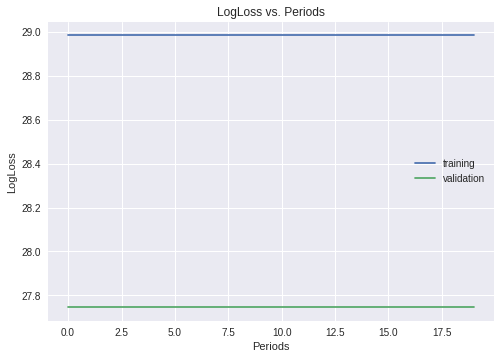

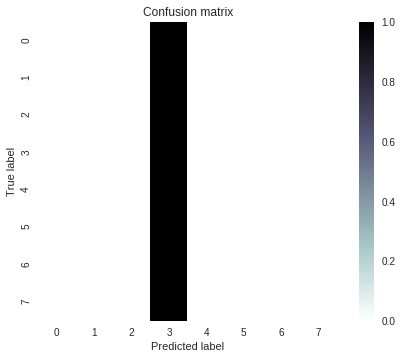

In [343]:
classifier = train_nn_classification_model(
    learning_rate=0.003,
    regularization_strength=0.03,
    steps=10000,
    batch_size=70,
    hidden_units=[50, 40, 30, 20, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    price_lookback=price_lookback,
    volume_lookback=volume_lookback,
    change_lookback=change_lookback)